<a href="https://colab.research.google.com/github/williamedwardhahn/OISC/blob/main/Hahn_MPCR_OISC_Logo_October_3rd_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MPCR OISC

In [ ]:
# Thing <- Name of the thing <- Name of the Name of the thing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 4096

def load_from_string(content):

    content += '''PS'''

    lines = [line.split('#')[0].strip() for line in content.split("\n") if line.split('#')[0]]

    C = np.zeros(N, dtype='object')
    D = {}
    i = 0
    for line in lines:

        tokens = line.strip().replace(',', ' ').split()
        D[tokens[0]] = i
        code = [D[token] if token in D else int(token) for token in tokens[1:]]

        if code:
            C[i] = i + 1
            C[i+1:i+1+len(code)] = code
            i += len(code) + 1
        else:
            i += 1

    return C, D


In [ ]:
code_ai = """
IP    # Instruction Pointer
A     # ALU Operand Register
B     # ALU Operand Register
C     # AUX Register
X     # AUX Register
Y     # AUX Register
Z     # AUX Register
I     # Loop Index
J     # Loop Index
K     # Loop Index
Add
Sub
Mult
Div
Equal
Greater
Lesser
L
S
W
P
Halt 0,L L,0
Push A,S W,0
Peek S,A A,S W,0
Pop S,A W,0
Drop S,C W,0
Dup S,A A,S A,S W,0
Swap S,B S,A B,S A,S W,0
Zero 0,L L,S W,0
One 1,L L,S W,0
+ S,B S,A Add,S W,0
- S,B S,A Sub,S W,0
* S,B S,A Mult,S W,0
/ S,B S,A Div,S W,0
Not S,A -1,L L,B Mult,A 1,L L,B Add,S W,0
Negate S,A -1,L L,B Mult,S W,0
Rot S,C S,B S,A C,S A,S B,S W,0
Continue A,A W,0
Branch Dup,W Not,W Rot,W *,W Rot,W *,W +,W S,A A,W W,0
If Continue,S Rot,W Branch,W W,0
Square Dup,W *,W W,0
Cube Dup,W Square,W *,W W,0
Fourth Square,W Square,W A,A W,0
Double Dup,W +,W W,0
-- S,A 1,L L,B Sub,S W,0
++ S,A 1,L L,B Add,S W,0
== S,B S,A Equal,S W,0
> S,B S,A Greater,S W,0
< S,B S,A Lesser,S W,0
!= ==,W Not,W W,0
Word1 Double,W W,0
Apple 0
Orange 0
! S,A S,P W,0
@ S,A P,S W,0
Halve S,A 2,L L,B Div,S W,0
Over S,B S,A A,S B,S A,S W,0
Mod S,Y S,X X,A Y,B Div,A Mult,B X,A Sub,S W,0
I-- I,S --,W S,I W,0
I++ I,S ++,W S,I W,0
I--Y0 I,S --,W S,I Y,0 W,0
Loop S,I I--,W S,X IP,Y X,W Continue,S I--Y0,S I,S One,W >,W Branch,W W,0
SL 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
WL 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Text 3 97 98 99 0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
"""

C, D = load_from_string(code_ai) # Codes, Dictionary

In [ ]:
#Decompiler
D2 = {v: k for k, v in D.items()}  # invert D
print(f"{'Index':<8}{'Name':<16}{'Code':<16}{'Decode':<16}")
for i in range(len(C) - 4000):  # Just showing the first 3 rows as an example
    value_name = D2.get(C[i], '')  # Check if the value has a corresponding name in D2
    if i in D2:
        print(f"{i:<8}{D2[i]:<16}{C[i]:<16}{value_name:<16}")
    else:
        print(f"{i:<8}{'':<16}{C[i]:<16}{value_name:<16}")


Index   Name            Code            Decode          
0       IP              0               IP              
1       A               0               IP              
2       B               0               IP              
3       C               0               IP              
4       X               0               IP              
5       Y               0               IP              
6       Z               0               IP              
7       I               0               IP              
8       J               0               IP              
9       K               0               IP              
10      Add             0               IP              
11      Sub             0               IP              
12      Mult            0               IP              
13      Div             0               IP              
14      Equal           0               IP              
15      Greater         0               IP              
16      Lesser          0      

In [ ]:
def is_integer(x):
    return x.lstrip('-').isdigit()

def value(token):
    return int(token) if is_integer(token) else D[token]

def compile_program(X):
    program = []
    tokens = X.split(' ')

    for token in tokens:
        if is_integer(token):
            program += [int(token), D['L'], D['L'], D['S']]
        elif ',' in token:
            a, b = token.split(',')
            program += [value(a), value(b)]
        else:
            program += [D[token], D['W']]    # Call Word

    program += [0, D['L'], D['L'], D['IP']]  # Halt
    return program



def setup(program):
    program = compile_program(program)
    M = np.zeros(N, dtype=int)
    M[:len(C)] = C
    M[D["PS"]:D["PS"] + len(program)] = program
    M[D["IP"]] = D["PS"]
    M[D["SL"]] = 0
    M[D["WL"]] = 0
    return M


def run(M):

    IP, A, B, C, Add, Sub, Mult, Div, L, P, S, SL, W, WL, Equal, Greater, Lesser = (D[x] for x in ["IP", "A", "B", "C", "Add", "Sub", "Mult", "Div", "L", "P", "S", "SL", "W", "WL", "Equal", "Greater", "Lesser"])

    while M[IP] > 0:

        M[IP] += 2

        a,b = M[IP]-2 , M[IP]-1  # a is pointer to address i, b is pointer to address j
        i,j = M[a]    , M[b]     # copy from address i paste in address j


        if j == L:
            M[L] = i
        elif i in [S, W]:
            if i == S:
                M[j] = M[SL + M[SL]]
                M[SL] -= 1
            else:
                M[j] = M[WL + M[WL]]
                M[WL] -= 1
        elif j in [S, W]:
            if j == S:
                M[SL] += 1
                M[SL + M[SL]] = M[i]
            else:
                M[WL] += 1
                M[WL + M[WL]] = M[0]
                M[0] = M[i]
        elif i == P:
            M[j] = M[M[A]]
        elif j == P:
            M[M[A]] = M[i]
        else:
            M[j] = M[i]


        #Memory Mapped ALU
        M[Add]  = M[A] + M[B]
        M[Sub]  = M[A] - M[B]
        M[Mult] = M[A] * M[B]
        M[Div]  = 0 if M[B] == 0 else M[A] // M[B]

        M[Equal]   = M[A] == M[B]
        M[Greater] = M[A] > M[B]
        M[Lesser]  = M[A] < M[B]


    return M



In [ ]:
# Test data
def check():
    assert np.array_equal(answer, np.array(expected_answer)), f'Test {program} failed. Expected {expected_answer}, but got {answer.tolist()}.'

test_programs = [
    ("10 11 +", [21]),                                     # Add 10 and 11
    ("10 3 -", [7]),                                       # Subtract 3 from 10
    ("8 9 *", [72]),                                       # Multiply 8 by 9
    ("10 2 /", [5]),                                       # Divide 10 by 2
    ("10 3 >", [1]),                                       # Check if 10 is greater than 3
    ("3 5 >", [0]),                                        # Check if 3 is greater than 5
    ("1 Not", [0]),                                        # Logical NOT of 1
    ("5 Fourth", [625]),                                   # Raise 5 to the power of 4
    ("8 9 * 7 + Fourth", [38950081]),                      # Multiply 8 and 9, add 7, and raise the result to the power of 4
    ("0 Not", [1]),                                        # Logical NOT of 0
    ("-5 Negate", [5]),                                    # Negate -5
    ("6 --", [5]),                                         # Decrement 6 by 1
    ("3 Double", [6]),                                     # Double the value 3
    ("3 5 -", [-2]),                                       # Subtract 5 from 3
    ("3 5 >", [0]),                                        # Check if 3 is greater than 5
    ("0 5 >", [0]),                                        # Check if 0 is greater than 5
    ("6 5 >", [1]),                                        # Check if 6 is greater than 5
    ("5 Double,S Fourth,S One Branch", [625]),             # Double 5, raise it to the power of 4, and branch based on 1 (true)
    ("5 Double,S Fourth,S Zero Branch", [10]),             # Double 5, raise it to the power of 4, and branch based on 0 (false)
    ("5 Continue,S Fourth,S One Branch 22 1 +", [625,23]), # Continue with operations, raise 5 to the power of 4, branch based on 1, add 22 and 1
    ("4 Halve", [2]),                                      # Divide 4 by 2
    ('2 4 + 3 -', [3]),                                    # Simple arithmetic
    ('2 2 2 2 2 + + + +', [10]),                           # Stacking operations
    ('5 2 * 10 /', [1]),                                   # Multiplication followed by division
    ('5 2 <', [0]),                                        # Lesser than check
    ('2 5 <', [1]),                                        # Lesser than check
    ('5 5 ==', [1]),                                       # Equality check
    ('5 3 !=', [1]),                                       # Non-equality check
    ('5 3 > 4 +', [5]),                                    # Greater than check with subsequent addition
    ('6 3 / 2 *', [4]),                                    # Division followed by multiplication
    ('2 5 > 3 4 + +', [7]),                                # Greater than check with subsequent operations
    ("10 3 Over", [10, 3, 10]),
    ("3 Cube", [27]),
    ("10 3 6 Rot", [6, 10, 3]),
    ("7 4 Mod", [3]),
    ("10 3 Mod", [1]),
    ("5 Continue,S Double,S One Branch", [10]),
    ("5 Double,S One If", [10]),
    ("5 Double,S Zero If", [5]),
    ("2 Word1,S 10 Loop", [1024]),
    ("2 Word1,S 8 Loop", [256]),
    ("5 S,Apple 10 Drop,W Apple,S", [5]),
    ]

test_programs += [(f"{i}", [i]) for i in range(100)]

for i, (program, expected_answer) in enumerate(test_programs):
    M = setup(program)
    M = run(M)
    answer = M[D['SL']+1:D['SL']+1+M[D['SL']]]
    check()

print('All tests passed.')

All tests passed.


#Display

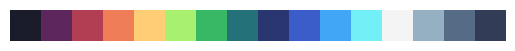

In [ ]:
import matplotlib.colors as mcolors
import imageio.v2 as imageio

def get_colors_lospec(im_array, N):
    rgb_list = im_array[0, :, :3] / 255
    float_list = np.linspace(0, 1, len(rgb_list))
    cdict = {}
    for num, col in enumerate(['red', 'green', 'blue']):
        cdict[col] = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
    return mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=N)

url = "https://lospec.com/palette-list/sweetie-16-1x.png"
# url = "https://lospec.com/palette-list/silent-five-1x.png"

im = imageio.imread(url)
colors = im.shape[1]
color_map = get_colors_lospec(im, colors)
plt.imshow(im, cmap=color_map),plt.axis('off');

n = 50
display = "DL" + n*n*" 0" + "\n"

def monitor():
    plt.imshow(M[D['DL']+1:D['DL']+n*n+1].reshape(n,n), cmap=color_map, vmin=0, vmax=colors)
    plt.colorbar()
    plt.show()
    plt.pause(0.1)

In [ ]:
new_code = '''
TurtleX
TurtleY
TurtleI
TurtleC
TurtleN
########
TurtleX-- TurtleX,S --,W S,TurtleX W,0
TurtleX++ TurtleX,S ++,W S,TurtleX W,0
TurtleY-- TurtleY,S --,W S,TurtleY W,0
TurtleY++ TurtleY,S ++,W S,TurtleY W,0
TurtleI++ TurtleI,S ++,W S,TurtleI W,0
Paint S,A TurtleC,P Drop,W W,0
UpdateTurtleI TurtleY,S TurtleN,S *,W TurtleX,S +,W DL,S +,W S,TurtleI W,0
Draw TurtleC,S UpdateTurtleI,W TurtleI,S Paint,W W,0
Start 50,L L,TurtleN 8,L L,TurtleX 12,L L,TurtleY 700,L L,TurtleI 1,L L,TurtleC Draw,W W,0
Up TurtleY--,W Draw,W W,0
Down TurtleY++,W Draw,W W,0
Left TurtleX--,W Draw,W W,0
Right TurtleX++,W Draw,W W,0
PenUp 0,L L,TurtleC W,0
PenDown 1,L L,TurtleC W,0
DrawA PenUp,W Right,W PenDown,W Right,S 3,L L,S Loop,W PenUp,W Right,W Down,W PenDown,W Down,S 4,L L,S Loop,W W,0
DrawSquare Right,S 10,L L,S Loop,W Down,S 10,L L,S Loop,W Left,S 10,L L,S Loop,W Up,S 10,L L,S Loop,W W,0
DrawSquares DrawSquare,W Right,S 9,L L,S Loop,W 2,L L,S S,TurtleC DrawSquare,W Right,S 9,L L,S Loop,W 3,L L,S S,TurtleC DrawSquare,W Right,S 9,L L,S Loop,W 4,L L,S S,TurtleC DrawSquare,W W,0
'''

In [ ]:
code0 = code_ai + display + new_code

In [ ]:
C, D = load_from_string(code0) # Codes, Dictionary

In [ ]:
program = "Start DrawSquares"
M = setup(program)

In [ ]:
# %%timeit
# run(M)

In [ ]:
M = run(M)

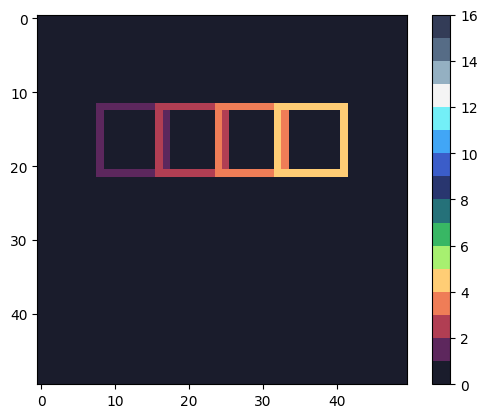

In [ ]:
monitor()

In [ ]:
def REPL(M):

    while True:

        print(M[D['SL']+1:D['SL']+1+M[D['SL']]])
        monitor()

        program = input()

        if program == "Exit": break

        program = compile_program(program)

        M[D["PS"]:D["PS"] + len(program)] = program
        M[0] = D["PS"]

        M = run(M)

In [ ]:
program = "0"
M = setup(program)
REPL(M)

# WASM

In [ ]:
<!DOCTYPE html>
<html>
<head>
	<meta charset="utf-8">
	<style>
		body {
			text-align: center;
		}
		canvas {

			margin: auto;
			display: block;
			width: 500px;  /* scale up canvas width */
			height: 500px;  /* scale up canvas height */
			image-rendering: pixelated;
		}
	</style>
</head>
<body>
	<h1>Monitor</h1>
	<canvas id="monitorCanvas" width="50" height="50"></canvas>  <!-- set actual canvas dimensions -->
</body>
<script>

function updateCanvas(arrayData, n) {
    console.log("Received arrayData: ", arrayData);  // Debugging line
    console.log("Received n: ", n);  // Debugging line

    const canvas = document.getElementById('monitorCanvas');
    const ctx = canvas.getContext('2d');
    const imgData = ctx.createImageData(n, n);
    const pixels = imgData.data;

    const parsedData = JSON.parse(arrayData);  // Parse the JSON string to an array

    if (parsedData.length !== n * n) {
        console.error("Data length mismatch: ", parsedData.length, " Expected: ", n * n);  // Debugging line
        return;
    }

    for (let y = 0; y < n; y++) {
        for (let x = 0; x < n; x++) {
            const pixelIndex = (y * n + x) * 4;
            const value = parsedData[y * n + x];
            pixels[pixelIndex] = 25 * value;
            pixels[pixelIndex + 1] = 25 * value;
            pixels[pixelIndex + 2] = 25 * value;
            pixels[pixelIndex + 3] = 255;
        }
    }
    ctx.putImageData(imgData, 0, 0);
}



</script>
<script src="https://pygame-web.github.io/archives/0.7/pythons.js" type=module id="site" data-os="fs,vtx,gui" async defer>

import asyncio
from js import updateCanvas
import numpy as np
import json



def monitor(M, D, n):
	arrayData = M[D['DL']+1:D['DL']+n*n+1].tolist()
	arrayDataStr = json.dumps(arrayData)
	updateCanvas(arrayDataStr, n)




async def main():

	N = 4096

	def load_from_string(content):
		content += '''PS'''
		lines = [line.split('#')[0].strip() for line in content.split("\n") if line.split('#')[0]]

		C = np.zeros(N, dtype='object')
		D = {}
		i = 0
		for line in lines:
			tokens = line.strip().replace(',', ' ').split()

			# Check if the key already exists in D
			if tokens[0] not in D:
				D[tokens[0]] = i

			code = [D[token] if token in D else int(token) for token in tokens[1:]]

			if code:
				C[i] = i + 1
				C[i+1:i+1+len(code)] = code
				i += len(code) + 1
			else:
				i += 1
		return C, D



	def compile_program(X):
		program = []
		for x in X.split(' '):
			if x.lstrip("-").isdigit():
				program += [int(x), D['L'], D['L'], D['S']]
			elif "," in x:
				a, b = map(lambda y: int(y) if y.lstrip("-").isdigit() else D[y], x.split(','))
				program += [a, b]
			else:
				program += [D[x], D['W']]
		program += [0, D['L'], D['L'], D['IP']]
		return program



	def setup(program):
		program = compile_program(program)
		M = np.zeros(N, dtype=int)
		M[:len(C)] = C
		M[D["PS"]:D["PS"] + len(program)] = program
		M[D["IP"]] = D["PS"]
		M[D["SL"]] = 0
		M[D["WL"]] = 0
		return M



	def run(M):

		IP, A, B, C, Add, Sub, Mult, Div, L, P, S, SL, W, WL, Equal, Greater, Lesser = (D[x] for x in ["IP", "A", "B", "C", "Add", "Sub", "Mult", "Div", "L", "P", "S", "SL", "W", "WL", "Equal", "Greater", "Lesser"])


		while M[IP] > 0:

			M[IP] += 2

			a,b = M[IP]-2 , M[IP]-1  # a is pointer to address i, b is pointer to address j
			i,j = M[a]	, M[b]	 # copy from address i paste in address j


			if i == S and j == L:
				M[L] = i
			elif i == W and j == L:
				M[L] = i

			elif j == L:
				M[L] = i

			elif i == S:
				M[j] = M[SL + M[SL]]
				M[SL] -= 1
			elif j == S:
				M[SL] += 1
				M[SL + M[SL]] = M[i]

			elif i == W:
				M[j] = M[WL + M[WL]]
				M[WL] -= 1
			elif j == W:
				M[WL] += 1
				M[WL + M[WL]] = M[0]
				M[0] = M[i]

			elif i == P:
				M[j] = M[M[A]]
			elif j == P:
				M[M[A]] = M[i]

			else:
				M[j] = M[i]


			#Memory Mapped ALU
			M[Add]  = M[A] + M[B]
			M[Sub]  = M[A] - M[B]
			M[Mult] = M[A] * M[B]
			M[Div]  = 0 if M[B] == 0 else M[A] // M[B]

			M[Equal]   = M[A] == M[B]
			M[Greater] = M[A] > M[B]
			M[Lesser]  = M[A] < M[B]


		return M


	code_ai = """
	IP	# Instruction Pointer
	A	 # ALU Operand Register
	B	 # ALU Operand Register
	C	 # AUX Register
	X	 # AUX Register
	Y	 # AUX Register
	Z	 # AUX Register
	I	 # Loop Index
	J	 # Loop Index
	K	 # Loop Index
	Add
	Sub
	Mult
	Div
	Equal
	Greater
	Lesser
	L
	S
	W
	P
	Halt 0,L L,0
	Push A,S W,0
	Peek S,A A,S W,0
	Pop S,A W,0
	Drop S,C W,0
	Dup S,A A,S A,S W,0
	Swap S,B S,A B,S A,S W,0
	Zero 0,L L,S W,0
	One 1,L L,S W,0
	+ S,B S,A Add,S W,0
	- S,B S,A Sub,S W,0
	* S,B S,A Mult,S W,0
	/ S,B S,A Div,S W,0
	Not S,A -1,L L,B Mult,A 1,L L,B Add,S W,0
	Negate S,A -1,L L,B Mult,S W,0
	Rot S,C S,B S,A C,S A,S B,S W,0
	Continue A,A W,0
	Branch Dup,W Not,W Rot,W *,W Rot,W *,W +,W S,A A,W W,0
	If Continue,S Rot,W Branch,W W,0
	Square Dup,W *,W W,0
	Cube Dup,W Square,W *,W W,0
	Fourth Square,W Square,W A,A W,0
	Double Dup,W +,W W,0
	-- S,A 1,L L,B Sub,S W,0
	++ S,A 1,L L,B Add,S W,0
	== S,B S,A Equal,S W,0
	> S,B S,A Greater,S W,0
	< S,B S,A Lesser,S W,0
	Word1 Double,W W,0
	Apple 0
	Orange 0
	! S,A S,P W,0
	@ S,A P,S W,0
	Halve S,A 2,L L,B Div,S W,0
	Over S,B S,A A,S B,S A,S W,0
	Mod S,Y S,X X,A Y,B Div,A Mult,B X,A Sub,S W,0
	I-- I,S --,W S,I W,0
	I++ I,S ++,W S,I W,0
	I--Y0 I,S --,W S,I Y,0 W,0
	Loop S,I I--,W S,X IP,Y X,W Continue,S I--Y0,S I,S One,W >,W Branch,W W,0
	SL 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
	WL 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
	Text 3 97 98 99 0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
	"""


	C, D = load_from_string(code_ai) # Codes, Dictionary



	print("Loaded")


	# Test data
	number_test_programs = [(f"{i}", [i]) for i in range(100)]

	test_programs = [
		("10 11 +", [21]),									 # Add 10 and 11
		("10 3 -", [7]),									   # Subtract 3 from 10
		("8 9 *", [72]),									   # Multiply 8 by 9
		("10 2 /", [5]),									   # Divide 10 by 2
		("10 3 >", [1]),									   # Check if 10 is greater than 3
		("3 5 >", [0]),										# Check if 3 is greater than 5
		("1 Not", [0]),										# Logical NOT of 1
		("5 Fourth", [625]),								   # Raise 5 to the power of 4
		("8 9 * 7 + Fourth", [38950081]),					  # Multiply 8 and 9, add 7, and raise the result to the power of 4
		("0 Not", [1]),										# Logical NOT of 0
		("-5 Negate", [5]),									# Negate -5
		("6 --", [5]),										 # Decrement 6 by 1
		("3 Double", [6]),									 # Double the value 3
		("3 5 -", [-2]),									   # Subtract 5 from 3
		("3 5 >", [0]),										# Check if 3 is greater than 5
		("0 5 >", [0]),										# Check if 0 is greater than 5
		("6 5 >", [1]),										# Check if 6 is greater than 5
		("5 Double,S Fourth,S One Branch", [625]),			 # Double 5, raise it to the power of 4, and branch based on 1 (true)
		("5 Double,S Fourth,S Zero Branch", [10]),			 # Double 5, raise it to the power of 4, and branch based on 0 (false)
		("5 Continue,S Fourth,S One Branch 22 1 +", [625,23]), # Continue with operations, raise 5 to the power of 4, branch based on 1, add 22 and 1
		("4 Halve", [2]),									  # Divide 4 by 2
		('2 4 + 3 -', [3]),									# Simple arithmetic
		('2 2 2 2 2 + + + +', [10]),						   # Stacking operations
		('5 2 * 10 /', [1]),								   # Multiplication followed by division
		('5 2 <', [0]),										# Lesser than check
		('2 5 <', [1]),										# Lesser than check
		('5 5 ==', [1]),									   # Equality check
		('5 3 ==', [0]),									   # Non-equality check
		('5 3 > 4 +', [5]),									# Greater than check with subsequent addition
		('6 3 / 2 *', [4]),									# Division followed by multiplication
		('2 5 > 3 4 + +', [7]),								# Greater than check with subsequent operations
		("10 3 Over", [10, 3, 10]),
		("3 Cube", [27]),
		("10 3 6 Rot", [6, 10, 3]),
		("7 4 Mod", [3]),
		("10 3 Mod", [1]),
		("5 Continue,S Double,S One Branch", [10]),
		("5 Double,S One If", [10]),
		("5 Double,S Zero If", [5]),
		("2 Word1,S 10 Loop", [1024]),
		("2 Word1,S 8 Loop", [256]),
		("5 S,Apple 10 Drop,W Apple,S", [5]),
		]

	for i, (program, expected_answer) in enumerate(number_test_programs):
		M = setup(program)
		M = run(M)
		answer = M[D['SL']+1:D['SL']+1+M[D['SL']]]
		assert np.array_equal(answer, np.array(expected_answer)), f'Test {program} failed. Expected {expected_answer}, but got {answer.tolist()}.'

	for i, (program, expected_answer) in enumerate(test_programs):
		M = setup(program)
		M = run(M)
		answer = M[D['SL']+1:D['SL']+1+M[D['SL']]]
		assert np.array_equal(answer, np.array(expected_answer)), f'Test {program} failed. Expected {expected_answer}, but got {answer.tolist()}.'

	print('All tests passed.')



	n = 50
	display = "DL" + n*n*" 0" + "\n"


	new_code = '''
	TurtleX
	TurtleY
	TurtleI
	TurtleC
	TurtleN
	TurtleX-- TurtleX,S --,W S,TurtleX W,0
	TurtleX++ TurtleX,S ++,W S,TurtleX W,0
	TurtleY-- TurtleY,S --,W S,TurtleY W,0
	TurtleY++ TurtleY,S ++,W S,TurtleY W,0
	TurtleI++ TurtleI,S ++,W S,TurtleI W,0
	Paint S,A TurtleC,P Drop,W W,0
	UpdateTurtleI TurtleY,S TurtleN,S *,W TurtleX,S +,W DL,S +,W S,TurtleI W,0
	Draw TurtleC,S UpdateTurtleI,W TurtleI,S Paint,W W,0
	Start 50,L L,TurtleN 5,L L,TurtleX 5,L L,TurtleY 700,L L,TurtleI 1,L L,TurtleC Draw,W W,0
	Up TurtleY--,W Draw,W W,0
	Down TurtleY++,W Draw,W W,0
	Left TurtleX--,W Draw,W W,0
	Right TurtleX++,W Draw,W W,0
	PenUp 0,L L,TurtleC W,0
	PenDown 1,L L,TurtleC W,0
	DrawA PenUp,W Right,W PenDown,W Right,S 3,L L,S Loop,W PenUp,W Right,W Down,W PenDown,W Down,S 4,L L,S Loop,W W,0
	DrawSquare Right,S 10,L L,S Loop,W Down,S 10,L L,S Loop,W Left,S 10,L L,S Loop,W Up,S 10,L L,S Loop,W W,0
	DrawSquares DrawSquare,W Right,S 9,L L,S Loop,W 5,L L,S S,TurtleC DrawSquare,W Right,S 9,L L,S Loop,W 11,L L,S S,TurtleC DrawSquare,W Right,S 9,L L,S Loop,W 3,L L,S S,TurtleC DrawSquare,W W,0
	'''

	code0 = code_ai + display + new_code

	C, D = load_from_string(code0) # Codes, Dictionary

	program = "Start DrawSquares"
	M = setup(program)
	M = run(M)







	monitor(M, D, n)

	print("Done!")


asyncio.run(main())

</script>
</html>




In [ ]:
N = 4096

def load_from_string(content):

    content += '''PS'''

    lines = [line.split('#')[0].strip() for line in content.split("\n") if line.split('#')[0]]

    C = np.zeros(N, dtype='object')
    D = {}
    i = 0
    for line in lines:

        tokens = line.strip().replace(',', ' ').split()
        D[tokens[0]] = i
        code = [D[token] if token in D else int(token) for token in tokens[1:]]

        if code:
            C[i] = i + 1
            C[i+1:i+1+len(code)] = code
            i += len(code) + 1
        else:
            i += 1

    return C, D



def compile_program(X):
    program = []
    for x in X.split(' '):
        if x.lstrip("-").isdigit():
            program += [int(x), D['L'], D['L'], D['S']]
        elif "," in x:
            a, b = map(lambda y: int(y) if y.lstrip("-").isdigit() else D[y], x.split(','))
            program += [a, b]
        else:
            program += [D[x], D['W']]
    program += [0, D['L'], D['L'], D['IP']]
    return program



def setup(program):
    program = compile_program(program)
    M = np.zeros(N, dtype=int)
    M[:len(C)] = C
    M[D["PS"]:D["PS"] + len(program)] = program
    M[D["IP"]] = D["PS"]
    M[D["SL"]] = 0
    M[D["WL"]] = 0
    return M



def run(M):

    IP, A, B, C, Add, Sub, Mult, Div, L, P, S, SL, W, WL, Equal, Greater, Lesser = (D[x] for x in ["IP", "A", "B", "C", "Add", "Sub", "Mult", "Div", "L", "P", "S", "SL", "W", "WL", "Equal", "Greater", "Lesser"])


    while M[IP] > 0:

        M[IP] += 2

        a,b = M[IP]-2 , M[IP]-1  # a is pointer to address i, b is pointer to address j
        i,j = M[a]	, M[b]	 # copy from address i paste in address j


        if i == S and j == L:
            M[L] = i
        elif i == W and j == L:
            M[L] = i

        elif j == L:
            M[L] = i

        elif i == S:
            M[j] = M[SL + M[SL]]
            M[SL] -= 1
        elif j == S:
            M[SL] += 1
            M[SL + M[SL]] = M[i]

        elif i == W:
            M[j] = M[WL + M[WL]]
            M[WL] -= 1
        elif j == W:
            M[WL] += 1
            M[WL + M[WL]] = M[0]
            M[0] = M[i]

        elif i == P:
            M[j] = M[M[A]]
        elif j == P:
            M[M[A]] = M[i]

        else:
            M[j] = M[i]


        #Memory Mapped ALU
        M[Add]  = M[A] + M[B]
        M[Sub]  = M[A] - M[B]
        M[Mult] = M[A] * M[B]
        M[Div]  = 0 if M[B] == 0 else M[A] // M[B]

        M[Equal]   = M[A] == M[B]
        M[Greater] = M[A] > M[B]
        M[Lesser]  = M[A] < M[B]


    return M


code_ai = """
IP	# Instruction Pointer
A	 # ALU Operand Register
B	 # ALU Operand Register
C	 # AUX Register
X	 # AUX Register
Y	 # AUX Register
Z	 # AUX Register
I	 # Loop Index
J	 # Loop Index
K	 # Loop Index
Add
Sub
Mult
Div
Equal
Greater
Lesser
L
S
W
P
Halt 0,L L,0
Push A,S W,0
Peek S,A A,S W,0
Pop S,A W,0
Drop S,C W,0
Dup S,A A,S A,S W,0
Swap S,B S,A B,S A,S W,0
Zero 0,L L,S W,0
One 1,L L,S W,0
+ S,B S,A Add,S W,0
- S,B S,A Sub,S W,0
* S,B S,A Mult,S W,0
/ S,B S,A Div,S W,0
Not S,A -1,L L,B Mult,A 1,L L,B Add,S W,0
Negate S,A -1,L L,B Mult,S W,0
Rot S,C S,B S,A C,S A,S B,S W,0
Continue A,A W,0
Branch Dup,W Not,W Rot,W *,W Rot,W *,W +,W S,A A,W W,0
If Continue,S Rot,W Branch,W W,0
Square Dup,W *,W W,0
Cube Dup,W Square,W *,W W,0
Fourth Square,W Square,W A,A W,0
Double Dup,W +,W W,0
-- S,A 1,L L,B Sub,S W,0
++ S,A 1,L L,B Add,S W,0
== S,B S,A Equal,S W,0
> S,B S,A Greater,S W,0
< S,B S,A Lesser,S W,0
Word1 Double,W W,0
Apple 0
Orange 0
! S,A S,P W,0
@ S,A P,S W,0
Halve S,A 2,L L,B Div,S W,0
Over S,B S,A A,S B,S A,S W,0
Mod S,Y S,X X,A Y,B Div,A Mult,B X,A Sub,S W,0
I-- I,S --,W S,I W,0
I++ I,S ++,W S,I W,0
I--Y0 I,S --,W S,I Y,0 W,0
Loop S,I I--,W S,X IP,Y X,W Continue,S I--Y0,S I,S One,W >,W Branch,W W,0
SL 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
WL 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Text 3 97 98 99 0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
"""


C, D = load_from_string(code_ai) # Codes, Dictionary



print("Loaded")


# Test data
number_test_programs = [(f"{i}", [i]) for i in range(100)]

test_programs = [
    ("10 11 +", [21]),                                     # Add 10 and 11
    ("10 3 -", [7]),                                       # Subtract 3 from 10
    ("8 9 *", [72]),                                       # Multiply 8 by 9
    ("10 2 /", [5]),                                       # Divide 10 by 2
    ("10 3 >", [1]),                                       # Check if 10 is greater than 3
    ("3 5 >", [0]),                                        # Check if 3 is greater than 5
    ("1 Not", [0]),                                        # Logical NOT of 1
    ("5 Fourth", [625]),                                   # Raise 5 to the power of 4
    ("8 9 * 7 + Fourth", [38950081]),                      # Multiply 8 and 9, add 7, and raise the result to the power of 4
    ("0 Not", [1]),                                        # Logical NOT of 0
    ("-5 Negate", [5]),                                    # Negate -5
    ("6 --", [5]),                                         # Decrement 6 by 1
    ("3 Double", [6]),                                     # Double the value 3
    ("3 5 -", [-2]),                                       # Subtract 5 from 3
    ("3 5 >", [0]),                                        # Check if 3 is greater than 5
    ("0 5 >", [0]),                                        # Check if 0 is greater than 5
    ("6 5 >", [1]),                                        # Check if 6 is greater than 5
    ("5 Double,S Fourth,S One Branch", [625]),             # Double 5, raise it to the power of 4, and branch based on 1 (true)
    ("5 Double,S Fourth,S Zero Branch", [10]),             # Double 5, raise it to the power of 4, and branch based on 0 (false)
    ("5 Continue,S Fourth,S One Branch 22 1 +", [625,23]), # Continue with operations, raise 5 to the power of 4, branch based on 1, add 22 and 1
    ("4 Halve", [2]),                                      # Divide 4 by 2
    ('2 4 + 3 -', [3]),                                    # Simple arithmetic
    ('2 2 2 2 2 + + + +', [10]),                           # Stacking operations
    ('5 2 * 10 /', [1]),                                   # Multiplication followed by division
    ('5 2 <', [0]),                                        # Lesser than check
    ('2 5 <', [1]),                                        # Lesser than check
    ('5 5 ==', [1]),                                       # Equality check
    ('5 3 ==', [0]),                                       # Non-equality check
    ('5 3 > 4 +', [5]),                                    # Greater than check with subsequent addition
    ('6 3 / 2 *', [4]),                                    # Division followed by multiplication
    ('2 5 > 3 4 + +', [7]),                                # Greater than check with subsequent operations
    ("10 3 Over", [10, 3, 10]),
    ("3 Cube", [27]),
    ("10 3 6 Rot", [6, 10, 3]),
    ("7 4 Mod", [3]),
    ("10 3 Mod", [1]),
    ("5 Continue,S Double,S One Branch", [10]),
    ("5 Double,S One If", [10]),
    ("5 Double,S Zero If", [5]),
    ("2 Word1,S 10 Loop", [1024]),
    ("2 Word1,S 8 Loop", [256]),
    ("5 S,Apple 10 Drop,W Apple,S", [5]),
    ]

for i, (program, expected_answer) in enumerate(number_test_programs):
    M = setup(program)
    M = run(M)
    answer = M[D['SL']+1:D['SL']+1+M[D['SL']]]
    assert np.array_equal(answer, np.array(expected_answer)), f'Test {program} failed. Expected {expected_answer}, but got {answer.tolist()}.'

for i, (program, expected_answer) in enumerate(test_programs):
    M = setup(program)
    M = run(M)
    answer = M[D['SL']+1:D['SL']+1+M[D['SL']]]
    assert np.array_equal(answer, np.array(expected_answer)), f'Test {program} failed. Expected {expected_answer}, but got {answer.tolist()}.'

print('All tests passed.')



n = 50
display = "DL" + n*n*" 0" + "\n"


new_code = '''
TurtleX
TurtleY
TurtleI
TurtleC
TurtleN
TurtleX-- TurtleX,S --,W S,TurtleX W,0
TurtleX++ TurtleX,S ++,W S,TurtleX W,0
TurtleY-- TurtleY,S --,W S,TurtleY W,0
TurtleY++ TurtleY,S ++,W S,TurtleY W,0
TurtleI++ TurtleI,S ++,W S,TurtleI W,0
Paint S,A TurtleC,P Drop,W W,0
UpdateTurtleI TurtleY,S TurtleN,S *,W TurtleX,S +,W DL,S +,W S,TurtleI W,0
Draw TurtleC,S UpdateTurtleI,W TurtleI,S Paint,W W,0
Start 50,L L,TurtleN 5,L L,TurtleX 5,L L,TurtleY 700,L L,TurtleI 1,L L,TurtleC Draw,W W,0
Up TurtleY--,W Draw,W W,0
Down TurtleY++,W Draw,W W,0
Left TurtleX--,W Draw,W W,0
Right TurtleX++,W Draw,W W,0
PenUp 0,L L,TurtleC W,0
PenDown 1,L L,TurtleC W,0
# Notes Go Here
DrawA PenUp,W Right,W PenDown,W Right,S 3,L L,S Loop,W PenUp,W Right,W Down,W PenDown,W Down,S 4,L L,S Loop,W W,0
DrawSquare Right,S 10,L L,S Loop,W Down,S 10,L L,S Loop,W Left,S 10,L L,S Loop,W Up,S 10,L L,S Loop,W W,0
DrawSquares DrawSquare,W Right,S 9,L L,S Loop,W 5,L L,S S,TurtleC DrawSquare,W Right,S 9,L L,S Loop,W 11,L L,S S,TurtleC DrawSquare,W Right,S 9,L L,S Loop,W 3,L L,S S,TurtleC DrawSquare,W W,0
'''

code0 = code_ai + display + new_code

C, D = load_from_string(code0) # Codes, Dictionary

program = "Start DrawSquares"
M = setup(program)
M = run(M)
print("Done!")

Loaded
All tests passed.
Done!


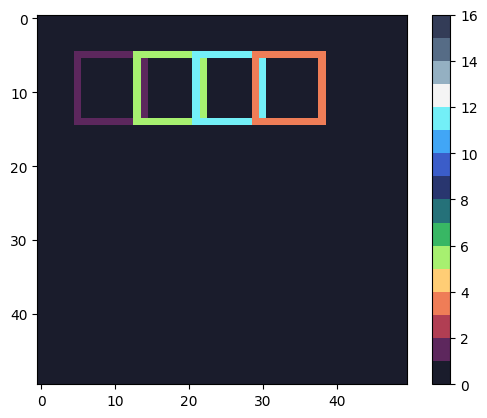

In [ ]:
monitor()

#Memory Mapped Server

In [ ]:
from flask import Flask, request, escape
import numpy as np

app = Flask(__name__)

FIXED_LENGTH = 100
arr = np.full((FIXED_LENGTH,), ord(' '), dtype=int)

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        # Convert input text to numpy array of ASCII values
        text = request.form.get('text_input')
        ascii_vals = [ord(char) for char in text.ljust(FIXED_LENGTH)[:FIXED_LENGTH]]

        global arr
        arr = np.array(ascii_vals)

    # Convert numpy array to ASCII string for display
    content = ''.join(chr(i) for i in arr)

    # HTML form for user input
    form_html = f'''
    <form method="post">
        <textarea name="text_input" rows="4" cols="50"></textarea><br>
        <input type="checkbox" name="debug" value="on"> Debug Mode<br>
        <input type="submit" value="Update"><br><br>
        <br>Rendered Content:<br>
        {content}
    </form>
    '''

    debug_output = ""
    if "debug" in request.form:
        # Display the numpy array, the raw ASCII, and the rendered HTML content
        debug_output = f'''
        <br>Integer Values:<br><br>
        {', '.join(map(str, arr))}<br>
        <br>Raw ASCII:<br>
        <pre><code>{escape(content)}</code></pre>
        '''



    return form_html + debug_output



app.run(host="0.0.0.0", port=8080, debug=True)


#Notes

In [ ]:
# def compile_program(X):
#     program = []
#     for x in X.split(' '):
#         if x.lstrip("-").isdigit():
#             program += [int(x), D['L'], D['L'], D['S']]
#         elif "," in x:
#             a, b = map(lambda y: int(y) if y.lstrip("-").isdigit() else D[y], x.split(','))
#             program += [a, b]
#         else:
#             program += [D[x], D['W']]
#     program += [0, D['L'], D['L'], D['IP']]
#     return program

In [ ]:
# def is_integer(s):
#     try:
#         int(s)
#         return True
#     except ValueError:
#         return False

# def compile_program(X):
#     program = []
#     for x in X.split(' '):
#         if is_integer(x):
#             program.extend([int(x), D['L'], D['L'], D['S']])
#         elif ',' in x:
#             a, b = x.split(',')
#             a = int(a) if is_integer(a) else D[a]
#             b = int(b) if is_integer(b) else D[b]
#             program.extend([a, b])
#         else:
#             program.extend([D[x], D['W']])

#     program.extend([0, D['L'], D['L'], D['IP']])
#     return program

In [ ]:
D['Text']
M[D['Text']]
M[M[D['Text']]]
chr(97)
output = ''.join([chr(i) for i in M[M[D['Text']]+1:M[D['Text']]+1+M[M[D['Text']]]]])
print(output)

In [ ]:
# if program == "Exit": break

In [ ]:
# https://www.dafont.com/img/charmap/r/e/retro_computer0.png

In [ ]:
plt.plot(M,'.')

In [ ]:
len(M)

In [ ]:
points = M[:50]#M[D["PS"]+1:D["PS"]+1 + len(program)]

In [ ]:
points.shape

In [ ]:
x_coords = points[0::2]
y_coords = points[1::2]

plt.scatter(x_coords, y_coords)